Take Home Assignment 3

3.0 Install any dependencies if needed 


In [1]:
!pip install supervision
!pip install ultralytics

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import time
import supervision as sv

3.1.1 Draw the segmentation mask of the largest car: Use ultralytics library only

In [7]:
img = cv2.imread("cars1.jpg")


0: 416x640 14 cars, 1485.4ms
Speed: 34.1ms preprocess, 1485.4ms inference, 73.3ms postprocess per image at shape (1, 3, 416, 640)


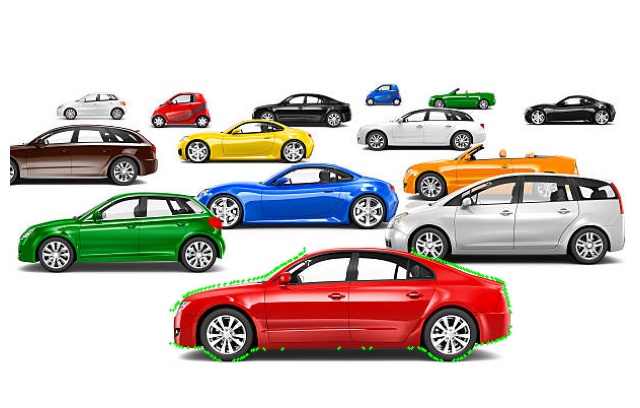

In [5]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the segmentation model (YOLOv8)
model = YOLO("yolov8n-seg.pt")  # YOLOv8 segmentation model

# Read the image
img = cv2.imread("cars1.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib

# Run the segmentation model
results = model(img)

largest_area = 0
largest_mask = None

# Iterate through detected objects
for result in results:
    for box, mask in zip(result.boxes.xyxy, result.masks.xy):
        x1, y1, x2, y2 = box  # Bounding box coordinates
        area = (x2 - x1) * (y2 - y1)  # Calculate area

        if area > largest_area:  # Find the largest car
            largest_area = area
            largest_mask = mask

# Draw the segmentation mask of the largest car
if largest_mask is not None:
    for segment in largest_mask:
        points = segment.reshape((-1, 1, 2)).astype(int)
        cv2.polylines(img_rgb, [points], isClosed=True, color=(0, 255, 0), thickness=2)
        cv2.fillPoly(img_rgb, [points], color=(0, 255, 0, 100))  # Fill the mask with transparency

# Display the image inside VS Code using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.axis("off")  # Hide axes
plt.show()  # Shows the image inside VS Code


3.1.2 Draw the segmentation mask of the largest car : Use ultralytics + supervision libraries


0: 416x640 14 cars, 668.5ms
Speed: 24.0ms preprocess, 668.5ms inference, 77.6ms postprocess per image at shape (1, 3, 416, 640)


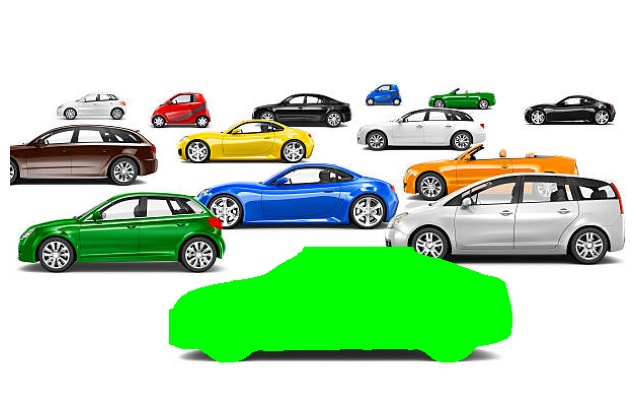

In [7]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import supervision as sv

# Load the segmentation model (YOLOv8)
model = YOLO("yolov8n-seg.pt")  # YOLOv8 segmentation model

# Read the image
img = cv2.imread("cars1.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib

# Run the segmentation model
results = model(img)

# Transfer results to supervision format
masks = []
areas = []
for result in results:
    for mask in result.masks.xy:
        # Convert mask from a list of points to a contour (polygon)
        mask = np.array(mask, dtype=np.int32)
        masks.append(mask)
        
        # Calculate the area of the segmentation mask
        # Create a blank mask to fill the region of interest (ROI)
        roi_mask = np.zeros(img.shape[:2], dtype=np.uint8)
        cv2.fillPoly(roi_mask, [mask], 255)  # Fill the mask area with 255
        
        # Calculate the area as the number of pixels in the mask
        area = np.sum(roi_mask == 255)
        areas.append(area)

# Find the largest mask (based on area)
if areas:
    largest_index = np.argmax(areas)  # Index of the largest area
    largest_mask = masks[largest_index]

    # Draw the largest mask on the image
    cv2.polylines(img_rgb, [largest_mask], isClosed=True, color=(0, 255, 0), thickness=2)
    cv2.fillPoly(img_rgb, [largest_mask], color=(0, 255, 0, 100))  # Fill the mask with transparency

# Display the result inside VS Code
plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.axis("off")  # Hide axes
plt.show()  # Shows the image inside VS Code


3.2 Estimate distance to centroid of chair 


0: 384x640 1 chair, 1121.6ms
Speed: 28.0ms preprocess, 1121.6ms inference, 44.0ms postprocess per image at shape (1, 3, 384, 640)
Estimated depth at chair centroid: 0.08756531774997711


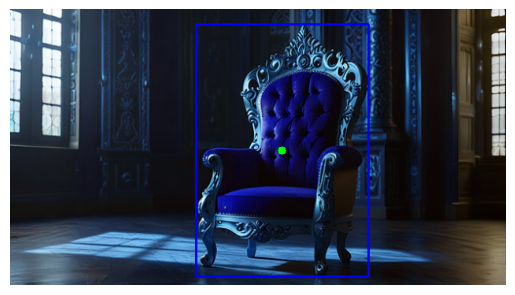

In [20]:
import cv2
import torch
import matplotlib.pyplot as plt
from depth_anything_v2.dpt import DepthAnythingV2
from ultralytics import YOLO
import torchvision.transforms as transforms

# Load the image
img_path = "kingChair.jpg"
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Error loading image: {img_path}")

# Convert BGR image to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Ensure image dimensions are multiples of 14
H, W, _ = img_rgb.shape
new_H = (H // 14) * 14  # Round down to the nearest multiple of 14
new_W = (W // 14) * 14  # Round down to the nearest multiple of 14
img_rgb = cv2.resize(img_rgb, (new_W, new_H))

# Load YOLOv5 object detection model (adjust path if needed)
detection_model = YOLO("yolo11s.pt")

# Perform object detection
results = detection_model(img_rgb)

# Find the centroid of the detected chair
centroid_x, centroid_y = None, None
for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Get bounding box coordinates
        label = result.names[int(box.cls[0])]
        if "chair" in label.lower():
            centroid_x = int((x1 + x2) / 2)
            centroid_y = int((y1 + y2) / 2)
            # Draw bounding box
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue box
            break
    if centroid_x is not None:
        break

if centroid_x is None or centroid_y is None:
    raise ValueError("No chair detected in the image.")

# Load Depth Anything V2 model for depth estimation
depth_model = DepthAnythingV2()

# Convert image to PyTorch tensor with correct shape
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts (H, W, C) to (C, H, W)
])
img_tensor = transform(img_rgb).unsqueeze(0)  # Add batch dimension (1, C, H, W)

# Run depth estimation
with torch.no_grad():
    depth_map = depth_model(img_tensor).squeeze(0).cpu().numpy()  # Convert back to NumPy

# Query depth at the centroid
chair_depth = depth_map[centroid_y, centroid_x]
print(f"Estimated depth at chair centroid: {chair_depth}")

# Draw centroid on the image
cv2.circle(img_rgb, (centroid_x, centroid_y), 5, (0, 255, 0), -1)  # Green dot

# Display the image with bounding box and centroid
plt.imshow(cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


3.3.1  Draw bounding boxes around the "cars" using supervision. 

In [18]:
import numpy as np
import supervision as sv
from ultralytics import YOLO

# Load YOLO model
model = YOLO("yolo11n.pt")

# Initialize Supervision annotator with bold green border
box_annotator = sv.BoxAnnotator(thickness=3, color=sv.Color.GREEN)

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # Perform inference
    results = model(frame)[0]
    
    # Extract bounding boxes, class IDs, and confidence scores
    detections = results.boxes.xyxy.cpu().numpy()  # Bounding boxes
    class_ids = results.boxes.cls.cpu().numpy().astype(int)  # Class IDs
    confidences = results.boxes.conf.cpu().numpy()  # Confidence scores
    
    # Create Supervision Detections object
    detections = sv.Detections(xyxy=detections, confidence=confidences, class_id=class_ids)
    
    # Filter detections to only include 'car' class (assuming class_id 2 for cars, check model labels)
    car_class_id = 2
    mask = detections.class_id == car_class_id
    detections = detections[mask]
    
    # Annotate frame with bold green bounding boxes
    frame = box_annotator.annotate(frame, detections)
    
    return frame

# Process video with supervision
sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="result_tracking.mp4",
    callback=callback
)

100%|██████████| 5.35M/5.35M [00:45<00:00, 124kB/s] 



0: 384x640 3 cars, 1 truck, 944.0ms
Speed: 52.0ms preprocess, 944.0ms inference, 68.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 663.1ms
Speed: 12.0ms preprocess, 663.1ms inference, 24.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 452.0ms
Speed: 24.0ms preprocess, 452.0ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 404.0ms
Speed: 28.0ms preprocess, 404.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 828.9ms
Speed: 32.0ms preprocess, 828.9ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 480.0ms
Speed: 12.0ms preprocess, 480.0ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 706.9ms
Speed: 8.0ms preprocess, 706.9ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 464.0ms
Speed: 8.0

3.3.1 Track the cars. Add the tracker id to the bounding boxes around the cars. Use supervision

In [21]:
import numpy as np
import supervision as sv
from ultralytics import YOLO
import cv2

# Load YOLO model
model = YOLO("yolo11n.pt")

# Initialize Supervision annotator with bold green border
box_annotator = sv.BoxAnnotator(thickness=3, color=sv.Color.GREEN)

# Initialize tracker
tracker = sv.ByteTrack()

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # Perform inference
    results = model(frame)[0]
    
    # Extract bounding boxes, class IDs, and confidence scores
    detections = results.boxes.xyxy.cpu().numpy()  # Bounding boxes
    class_ids = results.boxes.cls.cpu().numpy().astype(int)  # Class IDs
    confidences = results.boxes.conf.cpu().numpy()  # Confidence scores
    
    # Create Supervision Detections object
    detections = sv.Detections(xyxy=detections, confidence=confidences, class_id=class_ids)
    
    # Filter detections to only include 'car' class (assuming class_id 2 for cars, check model labels)
    car_class_id = 2
    mask = detections.class_id == car_class_id
    detections = detections[mask]
    
    # Track detections
    detections = tracker.update_with_detections(detections)
    
    # Prepare labels
    labels = [f"ID: {tracker_id}" for tracker_id in detections.tracker_id]
    
    # Annotate frame with bold green bounding boxes
    frame = box_annotator.annotate(frame, detections)
    
    # Annotate labels separately with bold black text and larger size
    font_scale = 1.0  # Increase the font scale to make the text larger
    font_thickness = 2  # Thickness of the text
    for i, label in enumerate(labels):
        # Coordinates for the label
        x, y = int(detections.xyxy[i][0]), int(detections.xyxy[i][1]) - 10
        
        # Simulate bold text by drawing the text multiple times with slight offsets
        frame = cv2.putText(frame, label, (x-2, y-2), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)  # Shadow
        frame = cv2.putText(frame, label, (x, y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)  # Bold black
    
    return frame

# Process video with supervision
sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="result_tracking_id.mp4",
    callback=callback
)


0: 384x640 3 cars, 1 truck, 3893.6ms
Speed: 1998.6ms preprocess, 3893.6ms inference, 32.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 1112.7ms
Speed: 20.0ms preprocess, 1112.7ms inference, 516.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 420.0ms
Speed: 136.0ms preprocess, 420.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 364.0ms
Speed: 4.0ms preprocess, 364.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 364.0ms
Speed: 8.0ms preprocess, 364.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 360.0ms
Speed: 8.0ms preprocess, 360.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 352.0ms
Speed: 4.0ms preprocess, 352.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 644.0ms
Speed

3.3.2 Draw the track traces for the tracked cars. Use supervision

In [22]:
# Initialize Supervision annotator with bold green border
box_annotator = sv.BoxAnnotator(thickness=3, color=sv.Color.GREEN)

# Initialize tracker
tracker = sv.ByteTrack()

# To keep track of positions over time
track_history = {}

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # Perform inference
    results = model(frame)[0]
    
    # Extract bounding boxes, class IDs, and confidence scores
    detections = results.boxes.xyxy.cpu().numpy()  # Bounding boxes
    class_ids = results.boxes.cls.cpu().numpy().astype(int)  # Class IDs
    confidences = results.boxes.conf.cpu().numpy()  # Confidence scores
    
    # Create Supervision Detections object
    detections = sv.Detections(xyxy=detections, confidence=confidences, class_id=class_ids)
    
    # Filter detections to only include 'car' class (assuming class_id 2 for cars, check model labels)
    car_class_id = 2
    mask = detections.class_id == car_class_id
    detections = detections[mask]
    
    # Track detections
    detections = tracker.update_with_detections(detections)
    
    # Prepare labels
    labels = [f"ID: {tracker_id}" for tracker_id in detections.tracker_id]
    
    # Annotate frame with bold green bounding boxes
    frame = box_annotator.annotate(frame, detections)
    
    # Annotate labels separately with bold black text and larger size
    font_scale = 1.0  # Increase the font scale to make the text larger
    font_thickness = 2  # Thickness of the text
    for i, label in enumerate(labels):
        # Coordinates for the label
        x, y = int(detections.xyxy[i][0]), int(detections.xyxy[i][1]) - 10
        
        # Simulate bold text by drawing the text multiple times with slight offsets
        frame = cv2.putText(frame, label, (x-2, y-2), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)  # Shadow
        frame = cv2.putText(frame, label, (x, y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)  # Bold black
    
    # Draw track traces (paths) for the tracked cars
    for i, tracker_id in enumerate(detections.tracker_id):
        car_id = int(tracker_id)
        
        # Get current car position
        car_position = (int(detections.xyxy[i][0] + (detections.xyxy[i][2] - detections.xyxy[i][0]) / 2),
                        int(detections.xyxy[i][1] + (detections.xyxy[i][3] - detections.xyxy[i][1]) / 2))  # Center of the bounding box
        
        # If the tracker_id has been seen before, add the position to its history
        if car_id not in track_history:
            track_history[car_id] = []
        track_history[car_id].append(car_position)
        
        # Draw the track trace (path) for the car
        if len(track_history[car_id]) > 1:
            # Draw the path by connecting points
            for j in range(1, len(track_history[car_id])):
                cv2.line(frame, track_history[car_id][j-1], track_history[car_id][j], (0, 0, 255), 2)  # Green trace
    
    return frame

# Process video with supervision
sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="result_tracking_with_trace.mp4",
    callback=callback
)


0: 384x640 3 cars, 1 truck, 4440.6ms
Speed: 671.7ms preprocess, 4440.6ms inference, 60.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 799.9ms
Speed: 16.0ms preprocess, 799.9ms inference, 12.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 760.0ms
Speed: 16.0ms preprocess, 760.0ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 455.5ms
Speed: 12.0ms preprocess, 455.5ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 360.0ms
Speed: 20.0ms preprocess, 360.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 548.0ms
Speed: 4.0ms preprocess, 548.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 408.0ms
Speed: 28.0ms preprocess, 408.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 388.2ms
Speed: 

Questions:

Explain what "def callback(frame: np.ndarray, _: int) -> np.ndarray:" does. 

Answers: 

The function definition def callback(frame: np.ndarray, _: int) -> np.ndarray: suggests that it is designed to process frames in applications like image processing, video analysis, or real-time data handling.

Breakdown of Its Purpose:

    Callback Function:
    The name "callback" indicates that this function is intended to be called automatically in response to an event, such as receiving a new video frame. Callback functions are commonly used in real-time applications like video streaming and live data processing.

    Parameters:
    frame: np.ndarray: The function takes a NumPy array as input, which likely represents an image or video frame. In image processing, frames are often stored as 2D (grayscale) or 3D (color) arrays.
    _: int: The second parameter is an integer, but the underscore (_) suggests that its value is not used within the function. This is a common Python convention for ignoring parameters that must be included for compatibility but are not needed.

    Return Type (-> np.ndarray):
    The function is expected to return another NumPy array, implying that it modifies the input frame and returns the processed version. Possible operations include applying filters, detecting edges, adjusting brightness, or converting to grayscale.

Practical Use Cases:

Video Processing: In a video stream, each frame can be modified before being displayed or stored. For example, a callback function might add text overlays, detect objects, or apply color corrections.

Real-Time Analysis: In robotics or surveillance, camera frames might be processed as they arrive to identify motion, recognize faces, or detect anomalies.